
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Tensorflow version: 1.13.1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model will be saved to: /content/drive/My Drive/Colab Notebooks/flowers_classification/flowers_classification_conv2.h5
Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of samples: 3670
Number of training examples:   3500
Number of test examples:       100
Batch size:                    50


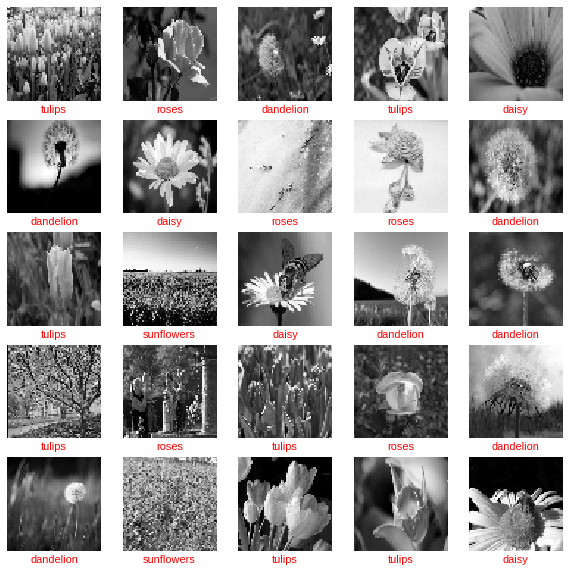

initializing the model
trying to load the model weights
model weights loaded!


In [1]:
%matplotlib inline

# Load the Drive helper and mount
from google.colab import drive

# for tensorboard log folder name
from time import time

# dealing with directories
import os                  

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print("Tensorflow version: {}".format(tf.__version__))

#------------------------------------------------------------------------------
# global constants
#------------------------------------------------------------------------------
LOAD_MODEL = True
TRAIN_MODEL = False
FOLDER_PREFIX = '/content/drive/My Drive/Colab Notebooks/flowers_classification'
MODEL_VARIANT_NAME = 'conv2'
MODEL_NAME = '{}{}'.format(
    FOLDER_PREFIX, '/flowers_classification_{}.h5'.format(MODEL_VARIANT_NAME))
TRAIN_BATCH_SIZE = 50
NUM_TRAIN_EXAMPLES = 3500
NUM_TEST_EXAMPLES = 100
IMGWIDTH = 64
IMGHEIGHT = 64

#------------------------------------------------------------------------------
# define functions
#------------------------------------------------------------------------------
def normalize(image, label):
    resized_image = tf.image.resize_images(image, (IMGWIDTH, IMGHEIGHT))
    grayscale_image = tf.image.rgb_to_grayscale(resized_image)
    normalized_grayscale_image = tf.cast(grayscale_image, tf.float32)
    normalized_grayscale_image /= 255
    # without this   1 - image   addition the images would be inverted
    normalized_grayscale_image = 1 - normalized_grayscale_image
    return normalized_grayscale_image, label
#------------------------------------------------------------------------------


# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()  

# This will prompt for authorization.
drive.mount('/content/drive')

print('Model will be saved to: {}'.format(MODEL_NAME))

dataset, metadata = tfds.load('tf_flowers', as_supervised=True, with_info=True)
print('Classes: {}'.format(metadata.features['label'].names))
print('Number of samples: {}'.format(metadata.splits['train'].num_examples))

all_data = dataset['train']
train_data = all_data.take(NUM_TRAIN_EXAMPLES)
test_data = all_data.skip(NUM_TRAIN_EXAMPLES)
test_data = test_data.take(NUM_TEST_EXAMPLES)

print("Number of training examples:   {}".format(NUM_TRAIN_EXAMPLES))
print("Number of test examples:       {}".format(NUM_TEST_EXAMPLES))
print("Batch size:                    {}".format(TRAIN_BATCH_SIZE))

train_data = train_data.map(normalize)
test_data = test_data.map(normalize)

plt.figure(figsize=(10,10))
i = 0
for (image, label) in train_data.take(25):
    image = image.numpy().reshape((IMGWIDTH,IMGHEIGHT))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    xlabel = plt.xlabel(metadata.features['label'].names[label])
    xlabel.set_color("red")
    i += 1
plt.show()


# load model or create a new model
print('initializing the model')
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), 
                           padding='same', 
                           activation=tf.nn.relu, 
                           input_shape=(IMGWIDTH, IMGHEIGHT, 1)),

    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (5, 5), 
                           padding='same',
                           activation=tf.nn.relu),

    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (5, 5), 
                           padding='same', 
                           activation=tf.nn.relu),

    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(256, (5, 5), 
                           padding='same', 
                           activation=tf.nn.relu),

    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(512, (5, 5), 
                           padding='same', 
                           activation=tf.nn.relu),

    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024, activation=tf.nn.relu),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(5,  activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

if LOAD_MODEL == True:
    print('trying to load the model weights')
    if os.path.exists(MODEL_NAME):
        model.load_weights(MODEL_NAME)
        print('model weights loaded!')
    else:
        print('loading the model weights failed: file does not exist')
    
if TRAIN_MODEL == True:
    print('training the model')

    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='{}{}'.format(FOLDER_PREFIX, '/logs/{}'.format(time())))

    train_data = train_data.repeat().shuffle(NUM_TRAIN_EXAMPLES).batch(TRAIN_BATCH_SIZE)

    test_data = test_data.batch(TRAIN_BATCH_SIZE)

    model.fit(train_data, 
              epochs=100, 
              steps_per_epoch=math.ceil(NUM_TRAIN_EXAMPLES/TRAIN_BATCH_SIZE),
              callbacks=[tensorboard])

    model.save_weights(MODEL_NAME)

    

Predictions and Reality (the first label is the prediction, the second one is the real value)


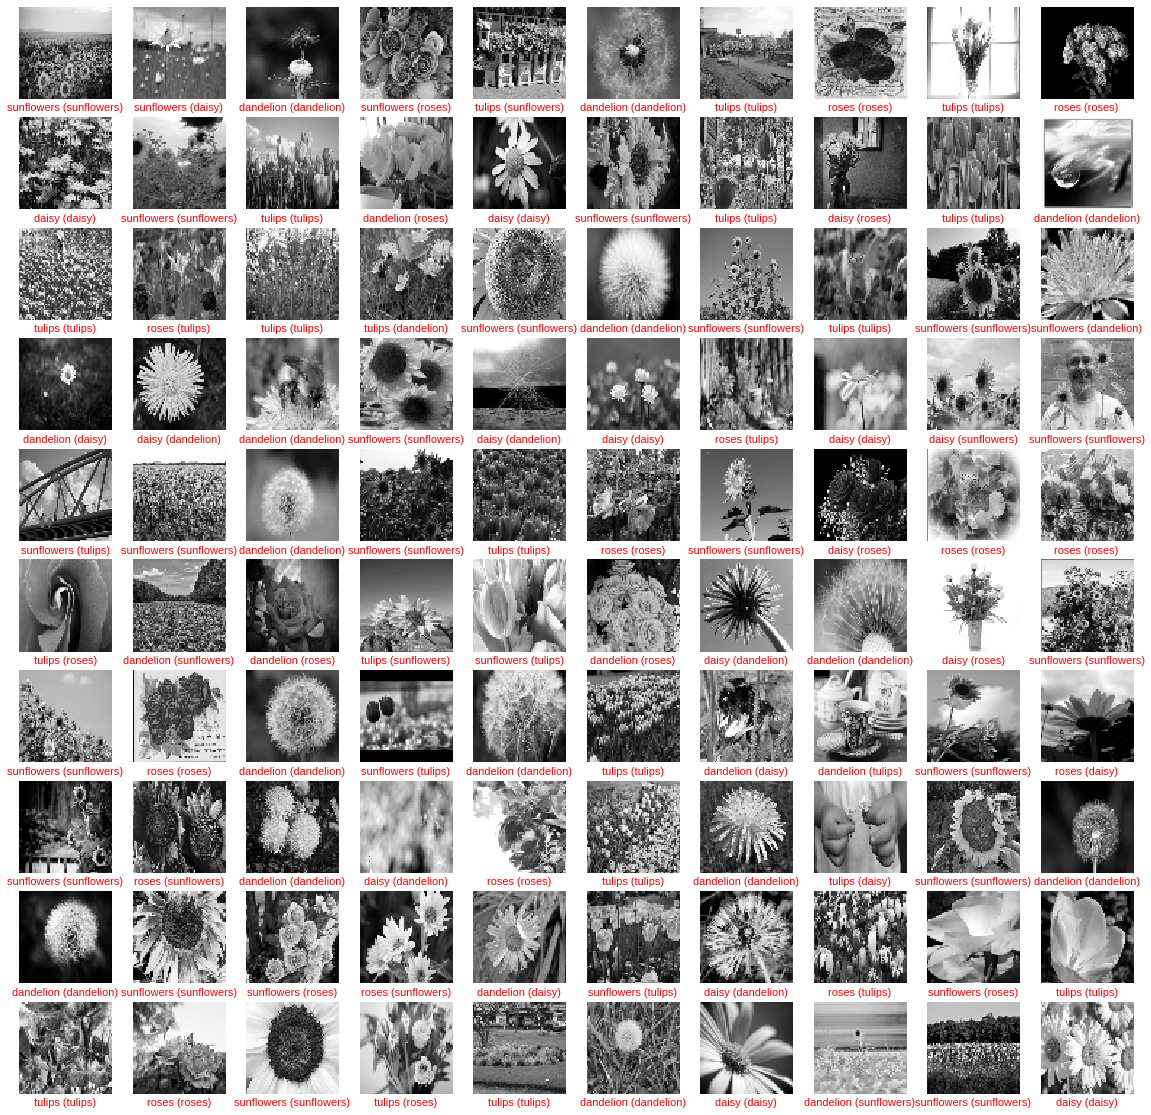

In [7]:
print('Predictions and Reality (the first label is the prediction, the second one is the real value)')
plt.figure(figsize=(20,20))
i = 0
for (image, label) in test_data.take(100):
    image = image.numpy().reshape(IMGHEIGHT, IMGHEIGHT)
    #label = label.numpy()

    image_for_prediction = image.reshape([-1, IMGWIDTH, IMGHEIGHT,1])
    predictions = model.predict(image_for_prediction)

    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    xlabel = plt.xlabel('{} ({})'.format(
        metadata.features['label'].names[np.argmax(predictions[0])],
        metadata.features['label'].names[label],
    ))
    xlabel.set_color("red")
    i += 1
plt.show()



predicted probabilities: [2.7203062e-10 1.0000000e+00 2.4229352e-14 1.3629896e-12 2.3053489e-22]
prediction:              daisy
correct value:           daisy
predicted probabilities: [1.0000000e+00 3.1824512e-34 2.6617575e-34 0.0000000e+00 6.8066655e-33]
prediction:              dandelion
correct value:           dandelion
predicted probabilities: [8.4816629e-01 4.8915516e-03 8.3175961e-05 8.9984126e-02 5.6874860e-02]
prediction:              dandelion
correct value:           tulips


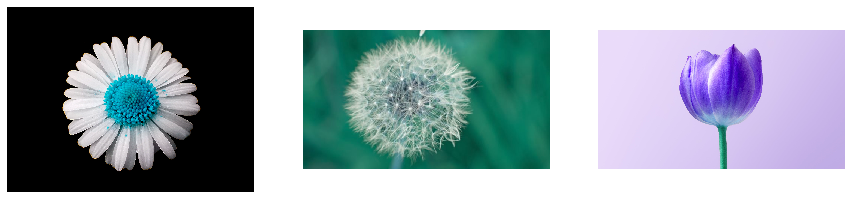

In [10]:
import cv2                 

plt.figure(figsize=(15,15))

testimgname = 'daisy1.jpg'
testlabel = 1
testimgpath = '{}/{}'.format(FOLDER_PREFIX, testimgname)
testimg = cv2.imread(testimgpath)

plt.subplot(1,3,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(testimg)

testimg, testlabel = normalize(testimg, testlabel)
image_for_prediction = np.array(testimg).reshape([-1, IMGWIDTH, IMGHEIGHT, 1])

predictions = model.predict(image_for_prediction)

print("predicted probabilities: {}".format(predictions[0]))
print("prediction:              {}".format(metadata.features['label'].names[np.argmax(predictions[0])]))
print("correct value:           {}".format(metadata.features['label'].names[testlabel]))



testimgname = 'dandelion.jpg'
testlabel = 0
testimgpath = '{}/{}'.format(FOLDER_PREFIX, testimgname)
testimg = cv2.imread(testimgpath)

plt.subplot(1,3,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(testimg)

testimg, testlabel = normalize(testimg, testlabel)
image_for_prediction = np.array(testimg).reshape([-1, IMGWIDTH, IMGHEIGHT, 1])

predictions = model.predict(image_for_prediction)

print("predicted probabilities: {}".format(predictions[0]))
print("prediction:              {}".format(metadata.features['label'].names[np.argmax(predictions[0])]))
print("correct value:           {}".format(metadata.features['label'].names[testlabel]))



testimgname = 'tulip.jpg'
testlabel = 2
testimgpath = '{}/{}'.format(FOLDER_PREFIX, testimgname)
testimg = cv2.imread(testimgpath)

plt.subplot(1,3,3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(testimg)

testimg, testlabel = normalize(testimg, testlabel)
image_for_prediction = np.array(testimg).reshape([-1, IMGWIDTH, IMGHEIGHT, 1])

predictions = model.predict(image_for_prediction)

print("predicted probabilities: {}".format(predictions[0]))
print("prediction:              {}".format(metadata.features['label'].names[np.argmax(predictions[0])]))
print("correct value:           {}".format(metadata.features['label'].names[testlabel]))

